# Model-X knockoffs

This tutorial is for generating model-X knockoffs, which handles cases where covariates outnumber sample size ($p > n$). The methodology is described in the following paper

> Candes E, Fan Y, Janson L, Lv J. *Panning for gold:‘model‐X’knockoffs for high dimensional controlled variable selection.* Journal of the Royal Statistical Society: Series B (Statistical Methodology). 2018 Jun;80(3):551-77.

In [1]:
# load packages needed for this tutorial
using Revise
using Knockoffs
using Plots
using Random
using GLMNet
using Distributions
using LinearAlgebra
using ToeplitzMatrices
using StatsBase
gr(fmt=:png);

[ Info: Precompiling Knockoffs [878bf26d-0c49-448a-9df5-b057c815d613]


## Gaussian model-X knockoffs with known mean and covariance

To illustrate, lets simulate data $\mathbf{X}$ with covariance $\Sigma$ and mean $\mu$. Our model is
```math
\begin{aligned}
    X_{p \times 1} \sim N(\mathbf{0}_p, \Sigma)
\end{aligned}
```
where
```math
\begin{aligned}
\Sigma = 
\begin{pmatrix}
    1 & \rho & \rho^2 & ... & \rho^p\\
    \rho & 1 & & ... & \rho^{p-1}\\
    \vdots & & & 1 & \vdots \\
    \rho^p & \cdots & & & 1
\end{pmatrix}
\end{aligned}
```
Given $n$ iid samples from the above distribution, we will generate knockoffs according to 
```math
\begin{aligned}
(X, \tilde{X}) \sim N
\left(0, \ 
\begin{pmatrix}
    \Sigma & \Sigma - diag(s)\\
    \Sigma - diag(s) & \Sigma
\end{pmatrix}
\right)
\end{aligned}
```
where $s$ is solved so that $0 \le s_j$ for all $j$ and $2Σ - diag(s)$ is PSD. 

In [3]:
Random.seed!(2022)
n = 100 # sample size
p = 500 # number of covariates
ρ = 0.4
Σ = Matrix(SymmetricToeplitz(ρ.^(0:(p-1)))) # true covariance matrix
μ = zeros(p) # true mean parameters
L = cholesky(Σ).L
X = randn(n, p) * L # var(X) = L var(N(0, 1)) L' = var(Σ)

100×500 Matrix{Float64}:
 -0.877527   -1.30346    -0.682964   …  -0.350442   -2.05031    -1.19774
  1.94981     0.625748   -0.157094       0.328944   -0.50083    -1.77715
 -0.372347   -0.0577255  -0.545009       2.04892     0.447051   -0.172137
  0.281239   -1.2314     -2.25883       -0.863995   -1.29658    -1.69292
 -1.94197    -0.514252   -0.126406       1.58385    -0.508209   -0.576327
  0.32584     1.29406    -0.944499   …   0.336041    0.834595    1.01313
  0.312506   -0.892288   -1.28543        0.656042   -0.727716   -0.062318
 -0.130798    0.080975   -1.00406        0.140716   -0.0171299   0.0520695
 -1.37595    -1.7559     -0.965395       0.475523    0.476843    0.0988572
  1.17982     1.1271      1.29655       -1.16738    -1.72623    -0.848002
  0.328697    0.674708    1.08453    …   0.886085   -0.405945   -0.190064
 -0.155799    0.740727    0.0747548      0.694317    0.483984    0.791628
 -2.03164    -0.90797    -1.57553        2.3821      1.89785     0.318261
  ⋮            

To generate knockoffs, the 4 argument function [modelX\_gaussian\_knockoffs](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.modelX_gaussian_knockoffs) will generate exact model-X knockoffs. The 2nd argument specifies the method to generate knockoffs. We generally recommend `:mvr` or `:maxent` because they are [more efficient to compute and tend to be more powerful than the SDP construction](https://projecteuclid.org/journals/annals-of-statistics/volume-50/issue-1/Powerful-knockoffs-via-minimizing-reconstructability/10.1214/21-AOS2104.short). The 3rd and 4th argument supplies the true mean and covariance of features.

In [3]:
@time equi = modelX_gaussian_knockoffs(X, :equi, μ, Σ)
@time mvr = modelX_gaussian_knockoffs(X, :mvr, μ, Σ)
@time me = modelX_gaussian_knockoffs(X, :maxent, μ, Σ);

 10.723081 seconds (33.00 M allocations: 1.706 GiB, 3.99% gc time, 99.28% compilation time)
  0.464159 seconds (65 allocations: 21.832 MiB)
  0.331323 seconds (63 allocations: 21.824 MiB)


The return type is a `GaussianKnockoff` struct, which contains the following fields

```julia
struct GaussianKnockoff{T<:AbstractFloat, M<:AbstractMatrix, S <: Symmetric} <: Knockoff
    X::M # n × p design matrix
    X̃::Matrix{T} # n × p knockoff of X
    s::Vector{T} # p × 1 vector. Diagonal(s) and 2Σ - Diagonal(s) are both psd
    Σ::S # p × p symmetric covariance matrix. 
    method::Symbol # method for solving s
end
```

Thus, to access these fields, one can do e.g.

In [4]:
s = mvr.s

500-element Vector{Float64}:
 0.7055844314114994
 0.5506002730046211
 0.5579639879044027
 0.5578996996307124
 0.5578836897138227
 0.5578849317983953
 0.5578848930158828
 0.5578848921854153
 0.5578848923414682
 0.5578848923277624
 0.5578848923226604
 0.5578848923174595
 0.5578848923122489
 ⋮
 0.5578848730689963
 0.5578848733890167
 0.55788487670645
 0.5578848743329733
 0.55788487452911
 0.5578848757524423
 0.5578849142012767
 0.5578836722536343
 0.5578996821189733
 0.5579639703133561
 0.5506002575404044
 0.7055843980219585

In [5]:
[me.s mvr.s equi.s]

500×3 Matrix{Float64}:
 0.760607  0.705584  0.85715
 0.599795  0.5506    0.85715
 0.611403  0.557964  0.85715
 0.610539  0.5579    0.85715
 0.610604  0.557884  0.85715
 0.610599  0.557885  0.85715
 0.610599  0.557885  0.85715
 0.610599  0.557885  0.85715
 0.610599  0.557885  0.85715
 0.610599  0.557885  0.85715
 0.610599  0.557885  0.85715
 0.610599  0.557885  0.85715
 0.610599  0.557885  0.85715
 ⋮                   
 0.610599  0.557885  0.85715
 0.610599  0.557885  0.85715
 0.610599  0.557885  0.85715
 0.610599  0.557885  0.85715
 0.610599  0.557885  0.85715
 0.610599  0.557885  0.85715
 0.610599  0.557885  0.85715
 0.610603  0.557884  0.85715
 0.610539  0.5579    0.85715
 0.611403  0.557964  0.85715
 0.599795  0.5506    0.85715
 0.760607  0.705584  0.85715

## Second order knockoffs

The 2 argument [modelX\_gaussian\_knockoffs](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.modelX_gaussian_knockoffs) will estimate the mean and covariance of `X` and use them to generate model-X knockoffs

In [7]:
# make 2nd order knockoffs
@time mvr_2nd_order = modelX_gaussian_knockoffs(X, :mvr);

  0.310257 seconds (107 allocations: 32.535 MiB)


## Approximate construction for speed

Generating model-X knockoffs scales as $\mathcal{O}(p^3)$ with coordinate descent (e.g. `sdp_fast`, `mvr`, `maxent`), which becomes prohibitively slow for large $p$ (e.g. $p = 5000$). 

Sometimes one expects that covariates are only correlated with its nearby neighbors. Then, we can approximate the covariance matrix as a block diagonal structure with block size `windowsize`, and solve each block independently as smaller problems. This is implemented as [approx\_modelX\_gaussian\_knockoffs](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.approx_modelX_gaussian_knockoffs)

In [9]:
@time mvr_approx = approx_modelX_gaussian_knockoffs(X, :mvr, windowsize=100);

  0.209562 seconds (516 allocations: 37.306 MiB)


## Multiple knockoffs

[Gimenez et al](http://proceedings.mlr.press/v89/gimenez19b.html) suggested multiple simultaneous knockoffs, which can give a boost in power when the target FDR or the number of variables to select are low. 

If one generated $m$ knockoffs for each of the $p$ variables, the convex optimization problem in solving for diagonal $S$ matrix is equally efficient as in the single-knockoff case, but the subsequent model selection would have $(m + 1) * p$ columns as opposed to $2p$ columns in the single-knockoff case. Thus, both computational speed and memory demand scales roughly linearly in $m$. 

In [15]:
m = 5
@time mvr_multiple = modelX_gaussian_knockoffs(X, :mvr, μ, Σ, m=m);

  0.994629 seconds (86 allocations: 180.907 MiB, 1.66% gc time)


As a sanity check, lets make sure the modified SDP constraint is satisfied

In [16]:
eigmin((m+1)/m * Σ - Diagonal(mvr_multiple.s))

0.035874264303699936

Finally, we can compare the `s` vector estimated from all 4 methods.

In [17]:
[mvr.s mvr_2nd_order.s mvr_approx.s mvr_multiple.s]

500×4 Matrix{Float64}:
 0.705584  0.765939  0.663288  0.642692
 0.5506    0.809085  0.697905  0.470063
 0.557964  1.04366   0.921063  0.476947
 0.5579    0.861391  0.761528  0.478338
 0.557884  0.911251  0.79024   0.478416
 0.557885  0.978195  0.86153   0.478416
 0.557885  0.919028  0.801034  0.478416
 0.557885  0.738538  0.667032  0.478416
 0.557885  0.867095  0.766879  0.478416
 0.557885  0.85405   0.741399  0.478416
 0.557885  0.71978   0.643369  0.478416
 0.557885  1.17217   1.0488    0.478416
 0.557885  0.827193  0.71336   0.478416
 ⋮                             
 0.557885  0.817116  0.69275   0.478416
 0.557885  0.991196  0.855442  0.478416
 0.557885  0.604032  0.534393  0.478416
 0.557885  0.67311   0.593851  0.478415
 0.557885  0.867173  0.765961  0.478416
 0.557885  0.877054  0.784296  0.478415
 0.557885  0.962095  0.843415  0.478416
 0.557884  1.09807   0.955455  0.478416
 0.5579    0.929815  0.821244  0.478338
 0.557964  0.961874  0.833572  0.476947
 0.5506    0.868215  0.77

In this example, they are quite different.

## LASSO example

Let us apply the generated knockoffs to the model selection problem

> Given response $\mathbf{y}_{n \times 1}$, design matrix $\mathbf{X}_{n \times p}$, we want to select a subset $S \subset \{1,...,p\}$ of variables that are truly causal for $\mathbf{y}$. 

### Simulate data

We will simulate 

$$\mathbf{y} \sim N(\mathbf{X}\mathbf{\beta}, \mathbf{\epsilon}), \quad \mathbf{\epsilon} \sim N(0, 1)$$

where $k=50$ positions of $\mathbf{\beta}$ is non-zero with effect size $\beta_j \sim N(0, 1)$. The goal is to recover those 50 positions using LASSO.

In [4]:
# set seed for reproducibility
Random.seed!(123)

# simulate true beta
n, p = size(X)
k = 50
βtrue = zeros(p)
βtrue[1:k] .= randn(k)
shuffle!(βtrue)

# find true causal variables
correct_position = findall(!iszero, βtrue)

# simulate y
y = X * βtrue + randn(n)

100-element Vector{Float64}:
  10.430304834810705
   9.430844234150015
   2.411065680091229
  14.925207979666721
  -8.743596474193755
   5.775257576204116
  -1.587996940979867
  13.605140626431009
 -18.781349632593464
   7.855239413947385
  -5.7381170081617405
  -4.631197619265106
 -11.89784179331142
   ⋮
 -10.887325590058026
  13.949139924153947
  -2.54163219529571
   3.1895938123917973
   1.0637262185056753
  -7.626490623432161
   1.8563101020426065
   1.066601624640122
  -7.242249824299234
  -3.2289570492580513
   4.014480647244052
   4.832304427120103

### Standard LASSO

Lets try running standard LASSO. We use LASSO solver in [GLMNet.jl](https://github.com/JuliaStats/GLMNet.jl) package, which is just a Julia wrapper for the GLMnet Fortran code. 

How does it perform in power and FDR?

In [5]:
# run 10-fold cross validation to find best λ minimizing MSE
lasso_cv = glmnetcv(X, y)
λbest = lasso_cv.lambda[argmin(lasso_cv.meanloss)]

# use λbest to fit LASSO on full data
βlasso = glmnet(X, y, lambda=[λbest]).betas[:, 1]

# check power and false discovery rate
power = length(findall(!iszero, βlasso) ∩ correct_position) / k
FDR = length(setdiff(findall(!iszero, βlasso), correct_position)) / count(!iszero, βlasso)
println("Lasso power = $power, FDR = $FDR")

Lasso power = 0.54, FDR = 0.7


More than half of all Lasso discoveries are false positives. 

### Knockoff+LASSO

Now lets try applying the knockoff methodology. Recall that consists of a few steps 

1. Run LASSO on $[\mathbf{X} \mathbf{\tilde{X}}]$
2. Compare feature importance score $W_j = \text{score}(x_j) - \text{score}(\tilde{x}_j)$ for each $j = 1,...,p$. Here we use $W_j = |\beta_j| - |\tilde{\beta}_{j}|$
3. Choose target FDR $q \in [0, 1]$ and compute 
$$\tau = min_{t}\left\{t > 0: \frac{{\{\#j: W_j ≤ -t}\}}{max(1, {\{\#j: W_j ≥ t}\})} \le q\right\}$$


!!! note
    
    In step 1, $[\mathbf{X} \mathbf{\tilde{X}}]$ is written for notational convenience. In practice one must interleave knockoffs with the original variables, where either the knockoff come first or the original genotype come first with equal probability. This is due to the inherent bias of LASSO solvers: when the original and knockoff variable are equally valid, the one listed first will be selected. We export a convenient function `merge_knockoffs_with_original` that performs this operation. 

The `fit_lasso` function generates knockoffs, run Lasso on $[\mathbf{X} \mathbf{\tilde{X}}]$, and apply knockoff filter:

In [18]:
@time knockoff_filter = fit_lasso(y, X, method=:mvr);

  0.380060 seconds (914 allocations: 58.746 MiB)


The return type is now a `LassoKnockoffFilter`, which contains the following information

```julia
struct LassoKnockoffFilter{T} <: KnockoffFilter
    y :: Vector{T} # n × 1 response vector
    X :: Matrix{T} # n × p matrix of original features
    ko :: Knockoff # A knockoff struct
    m :: Int # number of knockoffs per feature generated
    βs :: Vector{Vector{T}} # βs[i] is the p × 1 vector of effect sizes corresponding to fdr level fdr_target[i]
    a0 :: Vector{T}   # intercepts for each model in βs
    selected :: Vector{Vector{Int}} # selected[i] includes all variables selected based on target FDR level fdr_target[i]
    W :: Vector{T} # length p vector of feature importance
    τs :: Vector{T} # threshold for significance. For fdr fdr_target[i], τ[i] is threshold, and all W ≥ τ[i] is selected
    fdr_target :: Vector{T} # target FDR level for each τs and βs
    d :: UnivariateDistribution # distribution of y
    debias :: Union{Nothing, Symbol} # how βs and a0 have been debiased (`nothing` for not debiased)
end
```

Given these information, we can e.g. visualize power and FDR trade-off:

  0.408827 seconds (69.86 k allocations: 62.846 MiB, 0.59% gc time, 5.09% compilation time)
  0.408139 seconds (921 allocations: 58.774 MiB)
  0.372845 seconds (921 allocations: 59.096 MiB)
  0.369733 seconds (921 allocations: 58.775 MiB)
  0.387184 seconds (921 allocations: 58.774 MiB, 0.35% gc time)
  0.386038 seconds (921 allocations: 58.613 MiB)
  0.408438 seconds (921 allocations: 58.774 MiB, 0.27% gc time)
  0.376022 seconds (921 allocations: 58.775 MiB)
  0.394867 seconds (921 allocations: 58.774 MiB)
  0.403742 seconds (921 allocations: 58.774 MiB, 0.27% gc time)


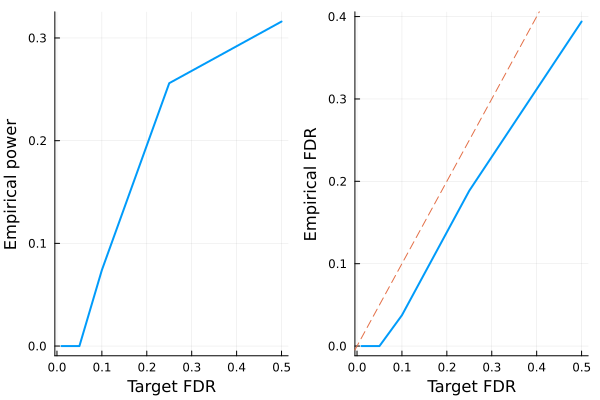

In [66]:
# run 10 simulations and compute empirical power/FDR
nsims = 10
empirical_power = zeros(5)
empirical_fdr = zeros(5)
for i in 1:nsims
    @time knockoff_filter = fit_lasso(y, X, method=:mvr)
    FDR = knockoff_filter.fdr_target
    for i in eachindex(FDR)
        selected = knockoff_filter.selected[i]
        power = length(selected ∩ correct_position) / k
        fdp = length(setdiff(selected, correct_position)) / max(length(selected), 1)
        empirical_power[i] += power
        empirical_fdr[i] += fdp
    end
end
empirical_power ./= nsims
empirical_fdr ./= nsims

# visualize FDR and power
power_plot = plot(FDR, empirical_power, xlabel="Target FDR", ylabel="Empirical power", legend=false, w=2)
fdr_plot = plot(FDR, empirical_fdr, xlabel="Target FDR", ylabel="Empirical FDR", legend=false, w=2)
Plots.abline!(fdr_plot, 1, 0, line=:dash)
plot(power_plot, fdr_plot)

### Multiple Knockoffs+LASSO

To improve selection stability, we can generate multiple simultaneous knockoffs. This is more computationally intensive but tends to boost power. 

  0.741831 seconds (1.97 k allocations: 268.344 MiB, 0.25% gc time)
  0.742101 seconds (1.97 k allocations: 266.900 MiB, 0.30% gc time)
  0.690350 seconds (1.97 k allocations: 266.900 MiB, 0.14% gc time)
  0.678163 seconds (1.97 k allocations: 267.863 MiB, 0.27% gc time)
  0.652373 seconds (1.97 k allocations: 267.381 MiB, 0.16% gc time)
  0.823302 seconds (1.97 k allocations: 267.381 MiB, 0.23% gc time)
  0.655046 seconds (1.97 k allocations: 267.381 MiB, 0.15% gc time)
  0.647079 seconds (1.97 k allocations: 267.863 MiB, 0.29% gc time)
  0.688816 seconds (1.97 k allocations: 266.900 MiB, 0.14% gc time)
  0.666808 seconds (1.97 k allocations: 269.307 MiB, 0.28% gc time)


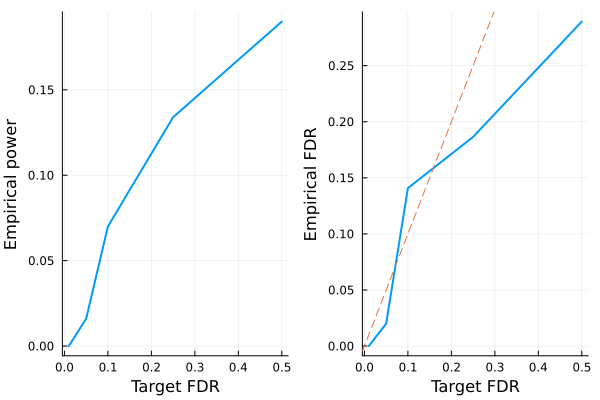

In [65]:
# run 10 simulations and compute empirical power/FDR
nsims = 10
empirical_power = zeros(5)
empirical_fdr = zeros(5)
for i in 1:nsims
    @time knockoff_filter = fit_lasso(y, X, method=:mvr, m=5);
    FDR = knockoff_filter.fdr_target
    for i in eachindex(FDR)
        selected = knockoff_filter.selected[i]
        power = length(selected ∩ correct_position) / k
        fdp = length(setdiff(selected, correct_position)) / max(length(selected), 1)
        empirical_power[i] += power
        empirical_fdr[i] += fdp
    end
end
empirical_power ./= nsims
empirical_fdr ./= nsims

# visualize FDR and power
power_plot = plot(FDR, empirical_power, xlabel="Target FDR", ylabel="Empirical power", legend=false, w=2)
fdr_plot = plot(FDR, empirical_fdr, xlabel="Target FDR", ylabel="Empirical FDR", legend=false, w=2)
Plots.abline!(fdr_plot, 1, 0, line=:dash)
plot(power_plot, fdr_plot)

**Conclusion:** 

+ LASSO + knockoffs controls the false discovery rate at below the target (dashed line). Thus, one trade power for FDR control. 
+ The power of standard LASSO is better, but it comes with high empirical FDR that one cannot control via cross validation. 
+ Multiple simultaneous knockoffs increases power at the expensive of larger regression problem. 